In [0]:
import csv
from gensim.models import Word2Vec
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, ThresholdedReLU, Flatten
from keras.models import Sequential
from tensorflow.keras import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import seaborn as sns
import re
import math
tf.test.gpu_device_name() 

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# downloaded = drive.CreateFile({'id':'1LAXYuJapp6u6shheA3ciIy67GrOQdlKs'}) 
# downloaded.GetContentFile('q2_revised.csv')  
df2 = pd.read_csv('/content/drive/Shared drives/Hackathon_new/q2_revised.csv', encoding='latin1')
# Dataset is now stored in a Pandas Dataframe
gt2 = pd.read_excel('/content/drive/Shared drives/Hackathon_new/q2_answer.xlsx')
alexa = pd.read_csv('/content/drive/Shared drives/Hackathon_new/alexa.csv', header=None, names=['dns'], usecols=[1])

words = pd.read_csv('/content/drive/Shared drives/Hackathon_new/google-10000-english.txt', sep=" ", header=None)
words.columns =["words"]

In [0]:
alexa = pd.read_csv('/content/drive/Shared drives/Hackathon_new/alexa.csv', header=None, names=['dns'], usecols=[1])


In [0]:
alexa

,dns
0,google.com
1,facebook.com
2,youtube.com
3,baidu.com
4,yahoo.com
...,...
999995,cfre.org
999996,fabricadericos.com
999997,earthrootgaming.com
999998,abusehoster.ru


In [0]:
words #top 10,000 meaningful words in domains from google



,words
0,the
1,of
2,and
3,to
4,a
...,...
9995,varieties
9996,arbor
9997,mediawiki
9998,configurations


In [0]:
df2.head()

,No.,Time,Source,Destination,Protocol,Length,Text item,Transaction ID,Name,Time.1,Reply code,Response,Primary name server,Info
0,1,0.000000,183.213.21.48,166.111.8.29,DNS,73,â\234\223,0x2719,weilaigou.com,NaN,NaN,Message is a query,NaN,Standard query 0x2719 A weilaigou.com
1,2,0.044210,8.8.8.8,101.6.69.132,DNS,102,â\234\223,0x51ae,taobao.com,NaN,No error,Message is a response,NaN,Standard query response 0x51ae A taobao.com A ...
2,3,0.069832,8.8.8.8,101.6.128.60,DNS,68,â\234\223,0xf102,sohu.com,NaN,Server failure,Message is a response,NaN,Standard query response 0xf102 Server failure ...
3,4,0.090890,144.217.10.132,166.111.124.17,DNS,79,â\234\223,0xbde3,hrsa.gov,NaN,NaN,Message is a query,NaN,Standard query 0xbde3 ANY hrsa.gov OPT
4,5,0.147890,183.173.94.53,8.8.8.8,DNS,70,â\234\223,0xb6ce,wahom.site,NaN,NaN,Message is a query,NaN,Standard query 0xb6ce A wahom.site


In [0]:

gt2[gt2.domain.str.contains("?", regex=False)] #found this random invalid domain in the answers



,domain,family
10992,????.cc,10


In [0]:
gt2.drop(10992, inplace=True)

In [0]:
gt2

,domain,family
0,z54f71fcb61e49158f3648236556b04eb1.so,1
1,l31f5dcf7f398d2b94cd9155ee392c701b.so,1
2,d442a48406424819e686a5d1fde7c602ea.so,1
3,zba909e91846ce27aff7902f9228ee40ea.so,1
4,p8f5889e854374cf8e70e91f456807f83f.so,1
...,...,...
11090,gdwrhiivyt.cc,10
11091,hyirnrnetku.cc,10
11092,isauvvu.cc,10
11093,vddiuiygf.cc,10


In [0]:
def extractDNS(info):
    info = info.split(' ')
    for s in info:
        if '.' in s:
            return s
    
    return ''

In [0]:
df2['dns'] = df2.Info.apply(extractDNS)

### prepare the data
input is the DNS string
output is 1 or 0. 1 means malicious and 0 means benign

In [0]:
data_x = df2.dns.unique()

In [0]:
x_set = set(data_x)
for dns in gt2.domain:
    if dns not in x_set:
        print(dns)

In [0]:
# there are some 42 dns are both in family 1 and 2. I guess
# they are in 2 since they end with '.ws'. 
gt_set = set()
repeat_dns = []
for dns in gt2.domain:
    if dns not in gt_set:
        gt_set.add(dns)
    else:
        repeat_dns.append(dns)

In [0]:
drop_idx = [] #drop index
for dns in repeat_dns:
    drop_idx.append(gt2[(gt2.domain==dns) & (gt2.family == 1)].index[0])

ngt2 = gt2.drop(drop_idx) #new answers
ngt2

,domain,family
0,z54f71fcb61e49158f3648236556b04eb1.so,1
1,l31f5dcf7f398d2b94cd9155ee392c701b.so,1
2,d442a48406424819e686a5d1fde7c602ea.so,1
3,zba909e91846ce27aff7902f9228ee40ea.so,1
4,p8f5889e854374cf8e70e91f456807f83f.so,1
...,...,...
11090,gdwrhiivyt.cc,10
11091,hyirnrnetku.cc,10
11092,isauvvu.cc,10
11093,vddiuiygf.cc,10


In [0]:
gt_set = set(ngt2.domain)
data_y = []
for dns in data_x:
    if dns in gt_set:
        data_y.append(1)
    else:
        data_y.append(0) #0 if not DGA
#data_y

In [0]:
p1_data = pd.DataFrame((zip(data_x, data_y)), columns =['dns', 'family'])
p1_data = p1_data.sample(frac=1, random_state=2020)
p1_data

,dns,family
47677,scylgroup.com,0
48162,effilnuds.com,0
28840,lovebookonline.com,0
4204,wwww91k.com,0
30276,93c53.com,0
...,...,...
18523,sousoucili.com,0
44739,ngmc.com,0
47734,weborama.fr,0
40259,mg4150.com,0


In [0]:
p1_data['dnsLength'] = p1_data.dns.apply(lambda x: len(x))


  

#We want to remove all domains with invalid characters

#Entropy Calculation

In [0]:
chrs = [c for c in p1_data.dns[2]]
d = ngrams(chrs, 3)
for grams in d:
  print(grams)

('s', 'o', 'h')
('o', 'h', 'u')
('h', 'u', '.')
('u', '.', 'c')
('.', 'c', 'o')
('c', 'o', 'm')


In [0]:
def ngramdict(dic, dns, i):
    grams = ngrams(getchars(dns), i)
    for gram in grams:
      string = "".join(list(gram))
      if not (string) in dic:
        dic[string] = 1
      else:
        dic[string] += 1  
    return dic

In [0]:
def cleandomain(domain):
  domain = re.sub('([\;!,?])','', domain) #remove random symbols
  #\\\\\(\)\[\]\=\*
  domain = domain.lower() #lowercase 
  if (domain.startswith('http://')):
    domain = domain[7:0]
    #print("t")
  if (domain.startswith('www.')): #remove www.
    domain = domain[4:]
  domain = domain.split(".", 1)[0] #the ending .com or .ru etc.
  return domain

In [0]:
def getchars(d):
  z = []
  for c in d:
    if (c == '/' or c== '&' or c == '\\\\' or c == '' or c == '(' or c == '[' or c == '?'): #for debugging purposes
      print(d)
    if (c == '&'):
      print(d)
    z.append(c)
  return z

In [0]:
for dns in gt_set:
  if ('?' in dns):
    print(dns)


In [0]:

malngramdictlist = []
for i in range(1,6):
  dic = {}
  for dns in gt_set:
    dic = ngramdict(dic, cleandomain(dns), i)
  malngramdictlist.append(dic)
malngramdictlist[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: generator 'ngrams' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


{'-': 316,
 '0': 2211,
 '1': 7804,
 '2': 2335,
 '3': 2341,
 '4': 2407,
 '5': 2319,
 '6': 2373,
 '7': 2381,
 '8': 2399,
 '9': 2430,
 'a': 7081,
 'b': 5353,
 'c': 6085,
 'd': 5569,
 'e': 7697,
 'f': 5361,
 'g': 4980,
 'h': 5298,
 'i': 6535,
 'j': 4668,
 'k': 4874,
 'l': 5606,
 'm': 5729,
 'n': 6673,
 'o': 6362,
 'p': 5544,
 'q': 4746,
 'r': 6263,
 's': 6474,
 't': 5957,
 'u': 5236,
 'v': 4637,
 'w': 4800,
 'x': 4594,
 'y': 4768,
 'z': 2856}

In [0]:
cnt = 0
for k,v in malngramdictlist[0].items():
  #print((k))
  cnt += v
#print(cnt)
for k in malngramdictlist[0]:
  malngramdictlist[0][k] = malngramdictlist[0].get(k)/float(cnt)


print(malngramdictlist[0]) #1 gram probabilities for malicious sites

{'k': 0.02816331719268239, 'r': 0.03618934254775745, 'c': 0.03516080942090118, 'q': 0.02742369786550485, '0': 0.012775768221793346, '3': 0.013526944100958038, 'd': 0.03217921900821671, 'm': 0.033103743167188636, '4': 0.013908310316533959, 's': 0.03740855878240168, '1': 0.045093665853855845, 'v': 0.02679386578220522, 'p': 0.03203476210837734, 'a': 0.04091597231050144, 'j': 0.026972992338006034, 'l': 0.03239301521997897, '7': 0.01375807514070102, 'e': 0.044475390322543364, 'g': 0.028775814448001296, 'y': 0.02755081993736349, 'f': 0.0309773376015532, 'b': 0.030931111393604604, 't': 0.03442119009372364, '6': 0.013711848932752424, '2': 0.01349227444499659, '9': 0.014041210664386173, '8': 0.013862084108585363, 'w': 0.027735724769157873, 'z': 0.016502756237648936, 'x': 0.026545399914481516, 'h': 0.030613306213958004, 'u': 0.03025505310235638, '5': 0.013399822029099399, 'o': 0.03676139187112133, 'n': 0.03855843570512302, 'i': 0.03776103361800973, '-': 0.00182593521396956}


In [0]:
mask = p1_data['family'].isin([0])
safedomain = p1_data[mask]
safedomain


,dns,family,dnsLength
47677,scylgroup.com,0,13
48162,effilnuds.com,0,13
28840,lovebookonline.com,0,18
4204,wwww91k.com,0,11
30276,93c53.com,0,9
...,...,...,...
1661,creditcardcity.com,0,18
18523,sousoucili.com,0,14
44739,ngmc.com,0,8
47734,weborama.fr,0,11


#BEGIN CLEANING SAFE DOMAIN DATA

for entropy I will disregard the ending like .cc .com etc. and only focus on the domain name. Later I will use ending as a feature. The purpose of this is so the entropy does not get corrupted. .com or .cc or .net are all common occurences and thus might make a random domain name seem less random

In [0]:

safedomain.dns = safedomain.dns.apply(lambda x: cleandomain(x))
print(safedomain[safedomain.dns.str.contains("?", regex=False)])
print(safedomain[safedomain.dns.str.contains(";", regex=False)])
print(safedomain[safedomain.dns.str.contains("&", regex=False)])
print(safedomain[safedomain.dns.str.contains("[", regex=False)])
print(safedomain[safedomain.dns.str.contains("]", regex=False)])
print(safedomain[safedomain.dns.str.contains("(", regex=False)])
print(safedomain[safedomain.dns.str.contains(")", regex=False)])
print(safedomain[safedomain.dns.str.contains("=", regex=False)])
print(safedomain[safedomain.dns.str.contains(":", regex=False)])
print(safedomain[safedomain.dns.str.contains("*", regex=False)])
print(safedomain[safedomain.dns.str.contains("!", regex=False)])
print(safedomain[safedomain.dns.str.contains("\\\\", regex=False)])
print(safedomain[safedomain.dns.str.contains("-", regex=False)])
print(safedomain[safedomain.dns.str.contains("_", regex=False)])








/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
                  dns  family  dnsLength
6952   icmesd2019&163       0         18
3923     esem2019&163       0         16
8146   icnisc2019&163       0         18
18293            &163       0          8
9038    icmse2019&163       0         17
19106       vault&shy       0         14
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
                      dns  family  dnsLength
23839    icmsb2019(at)163       0         20
30625   icnisc2019(at)163       0         21
51394  icnisc2019(dot)163       0         22
32110  (interdisciplinary       0         22
570      icmse2019(at)163       0         20
9746      jason(at)pepmic       0         19
2120              (amazon       0         11
7033    icmesd2019(at)163       0         21
                      dns  family  dnsLength
23839    icmsb2019(at)1

In [0]:
combined = list(set([*list(safedomain[safedomain.dns.str.contains("?", regex=False)].index),  
            *list(safedomain[safedomain.dns.str.contains(";", regex=False)].index), 
            *list(safedomain[safedomain.dns.str.contains("&", regex=False)].index), 
            *list(safedomain[safedomain.dns.str.contains("[", regex=False)].index),
            *list(safedomain[safedomain.dns.str.contains("]", regex=False)].index),
            *list(safedomain[safedomain.dns.str.contains("(", regex=False)].index),
            *list(safedomain[safedomain.dns.str.contains(")", regex=False)].index),
            *list(safedomain[safedomain.dns.str.contains("=", regex=False)].index),
            *list(safedomain[safedomain.dns.str.contains(":", regex=False)].index),
            *list(safedomain[safedomain.dns.str.contains("*", regex=False)].index),
            *list(safedomain[safedomain.dns.str.contains("!", regex=False)].index),
            *list(safedomain[safedomain.dns.str.contains("_", regex=False)].index),
            *list(safedomain[safedomain.dns.str.contains("\\", regex=False)].index)]))
#indexes of elements to remove
combined





[50817,
 30466,
 52355,
 13444,
 8580,
 38662,
 13445,
 24073,
 28554,
 1675,
 24081,
 9746,
 56339,
 22167,
 8343,
 3609,
 36507,
 2078,
 23839,
 51744,
 30625,
 19106,
 16161,
 55204,
 6952,
 10153,
 10154,
 38780,
 37552,
 30645,
 16568,
 570,
 2175,
 24256,
 51394,
 12099,
 2120,
 50889,
 29386,
 45644,
 9038,
 8146,
 3923,
 17106,
 40535,
 32218,
 44774,
 32110,
 18293,
 7033,
 28671,
 29820,
 6015]

In [0]:
#df = df[~df.datecolumn.isin(a)]

safedomain = safedomain[~safedomain.index.isin(combined)] #drop columns
safedomain = safedomain.drop_duplicates(subset='dns', keep="first") #remove duplicates
safedomain


,dns,family,dnsLength
47677,scylgroup,0,13
48162,effilnuds,0,13
28840,lovebookonline,0,18
4204,wwww91k,0,11
30276,93c53,0,9
...,...,...,...
1661,creditcardcity,0,18
18523,sousoucili,0,14
44739,ngmc,0,8
47734,weborama,0,11


In [0]:
print(safedomain[safedomain.dns.str.contains("?", regex=False)])
print(safedomain[safedomain.dns.str.contains(";", regex=False)])
print(safedomain[safedomain.dns.str.contains("&", regex=False)])
print(safedomain[safedomain.dns.str.contains("[", regex=False)])
print(safedomain[safedomain.dns.str.contains("]", regex=False)])
print(safedomain[safedomain.dns.str.contains("(", regex=False)])
print(safedomain[safedomain.dns.str.contains(")", regex=False)])
print(safedomain[safedomain.dns.str.contains("=", regex=False)])
print(safedomain[safedomain.dns.str.contains(":", regex=False)])
print(safedomain[safedomain.dns.str.contains("*", regex=False)])
print(safedomain[safedomain.dns.str.contains("!", regex=False)])
print(safedomain[safedomain.dns.str.contains("\\\\", regex=False)])
print(safedomain[safedomain.dns.str.contains("-", regex=False)])
print(safedomain[safedomain.dns.str.contains("_", regex=False)])

Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
Empty DataFrame
Columns: [dns, family, dnsLength]
Index: []
                    dns  family  dnsLength
31105       wwwwin-heng       0         15
15312         test-ipv6       0         12
24952     position-part       0         17
24297     candle-string       0         17
28750          g-energy       0         11
...                 ..

In [0]:
#1-6 grams
posgramdictlist = []
for i in range(1,6):
  dic = {}
  for dns in safedomain.dns:
    dic = ngramdict(dic, cleandomain(dns), i)
  posgramdictlist.append(dic)
posgramdictlist[0]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: generator 'ngrams' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


{'-': 3007,
 '0': 5348,
 '1': 8697,
 '2': 5043,
 '3': 4439,
 '4': 3740,
 '5': 4760,
 '6': 4654,
 '7': 4177,
 '8': 5550,
 '9': 4644,
 'a': 26746,
 'b': 11086,
 'c': 16612,
 'd': 13618,
 'e': 26759,
 'f': 9332,
 'g': 11928,
 'h': 12927,
 'i': 23241,
 'j': 7435,
 'k': 8759,
 'l': 14807,
 'm': 12690,
 'n': 21541,
 'o': 20337,
 'p': 10690,
 'q': 5530,
 'r': 16376,
 's': 19386,
 't': 17546,
 'u': 13787,
 'v': 6299,
 'w': 17668,
 'x': 7785,
 'y': 11089,
 'z': 6714}

In [0]:
cnt = 0
for k,v in posgramdictlist[0].items():
  #print((k))
  cnt += v
print(cnt)
for k in posgramdictlist[0]:
  posgramdictlist[0][k] = posgramdictlist[0].get(k)/float(cnt)


print(posgramdictlist[0]) #1 gram probabilities for safe sites

424747
{'s': 0.04564128763711103, 'c': 0.03911034097945365, 'y': 0.0261073062317097, 'l': 0.03486075240084097, 'g': 0.028082599759386175, 'r': 0.03855471610158518, 'o': 0.04788026754750475, 'u': 0.03245932284395181, 'p': 0.02516792349327953, 'e': 0.06299985638509513, 'f': 0.02197072610283298, 'i': 0.05471727875653036, 'n': 0.05071489616171509, 'd': 0.032061438927173114, 'v': 0.014830004685141979, 'b': 0.026100243203601204, 'k': 0.020621687734109953, 'w': 0.04159652687364478, '9': 0.010933567511954175, '1': 0.020475718486534338, '3': 0.010450927257873511, '5': 0.011206671265482747, 'j': 0.017504537995559708, 'h': 0.030434588119515854, 'q': 0.013019515146663779, 't': 0.041309297063899214, 'a': 0.06296924992995831, 'x': 0.01832855794155109, 'z': 0.01580705690681747, '-': 0.007079508507417356, 'm': 0.02987660889894455, '8': 0.013066602000720429, '6': 0.0109571109389825, '7': 0.009834089469731393, '0': 0.012591024774748261, '2': 0.011872950250384347, '4': 0.008805241708593587}


In [0]:
cnt = 0
for k,v in posgramdictlist[1].items():
  #print((k))
  cnt += v
print(cnt)
for k in posgramdictlist[1]:
  posgramdictlist[1][k] = posgramdictlist[1].get(k)/float(cnt)


print(posgramdictlist[1]) #2 gram probabilities for safe sites

380907
{'sc': 0.002045118624756174, 'cy': 0.0006747053742777109, 'yl': 0.0008243482004793821, 'lg': 0.0005303131735567999, 'gr': 0.001551559829564697, 'ro': 0.003265889049032966, 'ou': 0.0038014528480705264, 'up': 0.0012942791810074375, 'ef': 0.0010658769725943604, 'ff': 0.0010842541617770217, 'fi': 0.0014622991963917703, 'il': 0.003040112153360269, 'ln': 0.0005513156754798416, 'nu': 0.0007508394437487365, 'ud': 0.001273276679084396, 'ds': 0.001260150115382495, 'lo': 0.0029561021456681025, 'ov': 0.0010186213432675168, 've': 0.00238903459374598, 'eb': 0.0015095548257186137, 'bo': 0.001937480802400586, 'oo': 0.0025124242925438495, 'ok': 0.0011630135439884277, 'ko': 0.000955613837498392, 'on': 0.006720800615373306, 'nl': 0.001312656370190099, 'li': 0.004554917604559643, 'in': 0.010390987826424824, 'ne': 0.00464680355047295, 'ww': 0.017169545322086494, 'w9': 0.00038067034735512865, '91': 0.0009923682158637147, '1k': 0.00042530066394159206, '93': 0.00040692347475893063, '3c': 0.000317662841

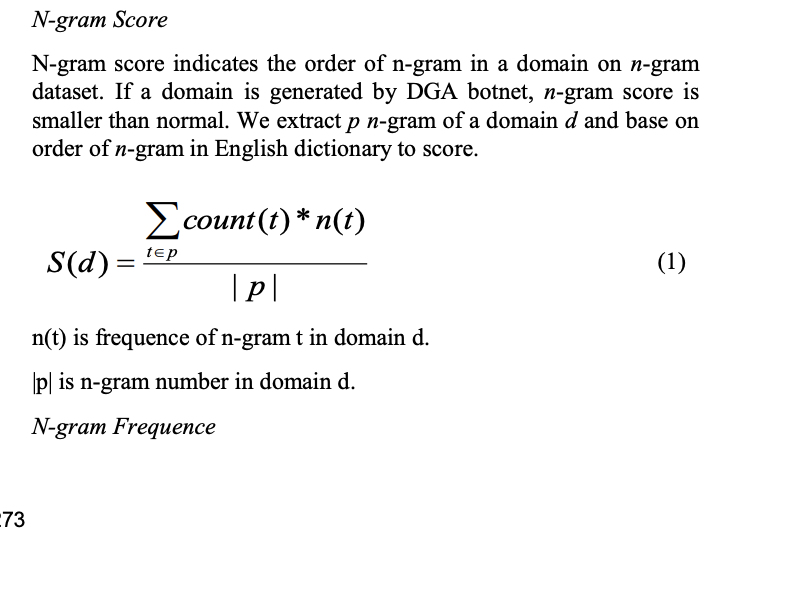

In [0]:
#https://dl.acm.org/doi/pdf/10.1145/3011077.3011112

def getngramscore(s, numgrams):
  count = 0
  d = ngrams([c for c in s], numgrams) #get numgrams grams and store in d
  for g in d:
    #print(g)
    count += posgramdictlist[numgrams-1].get("".join(list(g)))
  return count/max((float(len(s)-(numgrams-1))),1) #subtract numgrams minus 1 because this gives us how many ngrams there are. for 1 ngrams its just len(s) and 2 grams it's len(s)-1

    

In [0]:
print(getngramscore("test",1))
print(getngramscore("google",1))
print(getngramscore("zappos",1))
print(getngramscore("amazon",1))
print(getngramscore("zzyfhjzmm",1))
print(getngramscore("aaaaaaaaaa",1))

0.04781493453750115
0.04163105723328633
0.03710561816799177
0.045036221562483075
0.02257683855199553
0.06296924992995832


In [0]:
print(getngramscore("test",2))
print(getngramscore("google",2))
print(getngramscore("zappos",2))
print(getngramscore("amazon",2))
print(getngramscore("zzyfhjzmm",2))
print(getngramscore("aaaaaaaaaa",2))
print(getngramscore("testfdjslkf-nine",2))

0.004981968476994822
0.002131228882640645
0.0016287440241318746
0.003110995597350534
0.0005677238801072178
0.0011735147949499484
0.0024908967280727317


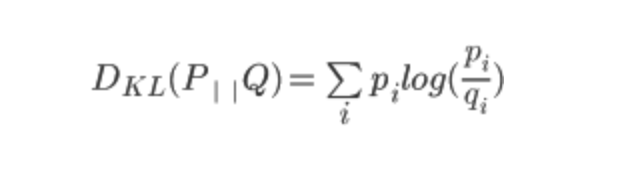

In [0]:
#https://redcanary.com/blog/threat-hunting-entropy/
def getentropy(s):
  tempdic = {}
  count = 0
  d = ngrams([c for c in s], 1) #get 1 grams and store in d
  for g in d:
    if not g in tempdic:
      tempdic[g] = 1/len(s)
    else:
      tempdic[g] += 1/len(s)
  for k, v in tempdic.items():
    count += (v*math.log2(v/posgramdictlist[0].get(list(k)[0])))
  return count



In [0]:
def getentropy2grams(s):
  tempdic = {}
  count = 0
  d = ngrams([c for c in s], 2) #get 1 grams and store in d
  for g in d:
    if not g in tempdic:
      tempdic[g] = 1/(len(s)-1) #subtract 1 because there are len(s) - 1 bigrams
    else:
      tempdic[g] += 1/(len(s)-1)
  for k, v in tempdic.items():
    count += (v*math.log2(v/posgramdictlist[1].get("".join(list(k)))))
  return count

In [0]:
print(getentropy("test"))
print(getentropy("google"))
print(getentropy("zappos"))
print(getentropy("amazon"))
print(getentropy("zzyfhjzmm"))
print(getentropy("aaaaaaaaaa"))


2.9092009259429754
2.7330324098804124
2.6542004640481167
2.3671068677612026
3.1052280070220184
3.9892087072539657


In [0]:
posgramdictlist[1].get("".join(list('t')))

In [0]:
print(getentropy2grams("test"))
print(getentropy2grams("google"))
print(getentropy2grams("zappos"))
print(getentropy2grams("amazon"))
print(getentropy2grams("zzyfhjzmm"))
print(getentropy2grams("aaaaaaaaaa"))

6.067358536331508
6.722348243906314
7.086724544781854
6.575777679570608
7.880444513038573
9.734948254078066


In [0]:
alexa['cleandns'] = alexa.dns.apply(lambda x: cleandomain(x))
alexa

,dns,cleandns
0,google.com,google
1,facebook.com,facebook
2,youtube.com,youtube
3,baidu.com,baidu
4,yahoo.com,yahoo
...,...,...
999995,cfre.org,cfre
999996,fabricadericos.com,fabricadericos
999997,earthrootgaming.com,earthrootgaming
999998,abusehoster.ru,abusehoster


In [0]:
#1-6 grams for alexa
alexagramlist = []
for i in range(1,6):
  dic = {}
  for dns in alexa.cleandns:
    dic = ngramdict(dic, cleandomain(dns), i)
  alexagramlist.append(dic)
alexagramlist[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: generator 'ngrams' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


{'-': 125372,
 '0': 19151,
 '1': 23971,
 '2': 23635,
 '3': 15017,
 '4': 16999,
 '5': 10947,
 '6': 9404,
 '7': 8960,
 '8': 10369,
 '9': 9365,
 '_': 136,
 'a': 964395,
 'b': 236937,
 'c': 389847,
 'd': 333503,
 'e': 1009906,
 'f': 167538,
 'g': 245414,
 'h': 263837,
 'i': 757715,
 'j': 53380,
 'k': 192951,
 'l': 484203,
 'm': 345125,
 'n': 626538,
 'o': 745990,
 'p': 293699,
 'q': 20297,
 'r': 661950,
 's': 669908,
 't': 630034,
 'u': 325465,
 'v': 136397,
 'w': 123376,
 'x': 62285,
 'y': 169924,
 'z': 67927}

In [0]:
cnt = 0
for k,v in alexagramlist[0].items():
  #print((k))
  cnt += v
print(cnt)
for k in alexagramlist[0]:
  alexagramlist[0][k] = alexagramlist[0].get(k)/float(cnt)


print(alexagramlist[0]) #1 gram probabilities for alexa top million sites

10251867
{'g': 0.0239384689637507, 'o': 0.07276625808742934, 'l': 0.04723071417137971, 'e': 0.09850947149431416, 'f': 0.016342194060847647, 'a': 0.09407018253358145, 'c': 0.03802692719287131, 'b': 0.02311159518554035, 'k': 0.018821059617726215, 'y': 0.01657493215625993, 'u': 0.031746900345078606, 't': 0.06145553780594305, 'i': 0.07390995220675414, 'd': 0.0325309526547701, 'h': 0.02573550749341559, 'm': 0.03366459982362237, 'z': 0.006625817521823098, 'n': 0.06111452674912774, 'w': 0.012034490888342582, 'p': 0.028648342784782517, 'q': 0.001979834502339915, 'r': 0.06456872684750982, 'v': 0.013304601005846057, 's': 0.06534497570052362, 'x': 0.006075478739628597, '1': 0.0023382082502630985, '2': 0.002305433732216776, '3': 0.0014648063616119875, '6': 0.0009172963324631504, '0': 0.0018680499854319217, 'j': 0.005206856468192574, '-': 0.012229187132451094, '9': 0.0009134921473327736, '5': 0.0010678055031342097, '7': 0.0008739871479019382, '8': 0.0010114255286378568, '4': 0.0016581370008019027, 

In [0]:
cnt = 0
for k,v in alexagramlist[1].items():
  #print((k))
  cnt += v
print(cnt)
for k in alexagramlist[1]:
  alexagramlist[1][k] = alexagramlist[1].get(k)/float(cnt)


print(alexagramlist[1]) #2 gram probabilities for alexa top million sites

9251867
{'go': 0.002284403785744002, 'oo': 0.0037796695521022947, 'og': 0.0023719536824297195, 'gl': 0.000995042406035452, 'le': 0.007771512495802198, 'fa': 0.002083579454827874, 'ac': 0.004408083254979779, 'ce': 0.004033996597659694, 'eb': 0.002866340382973512, 'bo': 0.0030249029736376452, 'ok': 0.0018792963625611997, 'yo': 0.0013534565509858714, 'ou': 0.004359120164611099, 'ut': 0.002841912880935275, 'tu': 0.00292751722436131, 'ub': 0.0018150931049916736, 'be': 0.003620998875145957, 'ba': 0.004040373688899764, 'ai': 0.003728977081058342, 'id': 0.0031048868298690414, 'du': 0.0012372637868659374, 'ya': 0.001620862037900026, 'ah': 0.001043248892358699, 'ho': 0.005545259135264266, 'am': 0.005472192801733964, 'ma': 0.008642363752094578, 'az': 0.0013349737950188864, 'zo': 0.0006766201892007311, 'on': 0.011047067581062288, 'wi': 0.0015406620090842205, 'ik': 0.0017252733961696596, 'ki': 0.002553754825917839, 'ip': 0.001768399826759291, 'pe': 0.003511183202266094, 'ed': 0.0043780352657469025,

In [0]:
cnt = 0
for k,v in alexagramlist[2].items():
  #print((k))
  cnt += v
print(cnt)
for k in alexagramlist[2]:
  alexagramlist[2][k] = alexagramlist[2].get(k)/float(cnt)


#print(alexagramlist[2]) #3 gram probabilities for alexa top million sites

8252015


In [0]:
cnt = 0
for k,v in alexagramlist[3].items():
  #print((k))
  cnt += v
print(cnt)
for k in alexagramlist[3]:
  alexagramlist[3][k] = alexagramlist[3].get(k)/float(cnt)


#print(alexagramlist[3]) #4 gram probabilities for alexa top million sites

7255559


In [0]:
cnt = 0
for k,v in alexagramlist[4].items():
  #print((k))
  cnt += v
print(cnt)
for k in alexagramlist[4]:
  alexagramlist[4][k] = alexagramlist[4].get(k)/float(cnt)


#print(alexagramlist[4]) #5 gram probabilities for alexa top million sites

6283225


In [0]:
def getalexangramscore(s, numgrams):
  #print(s)
  count = 0
  d = ngrams([c for c in s], numgrams) #get numgrams grams and store in d
  for g in d:
    #print(g)
    if ("".join(list(g)) in (alexagramlist[numgrams-1].keys())):
      count += alexagramlist[numgrams-1].get("".join(list(g)))
    else:
      continue
    #print(alexagramlist[numgrams-1].get("".join(list(g))))
  return count/max((float(len(s)-(numgrams-1))),1) #subtract numgrams minus 1 because this gives us how many ngrams there are. for 1 ngrams its just len(s) and 2 grams it's len(s)-1


In [0]:
print(getalexangramscore("google", 1))
print(getalexangramscore("facebook", 1))
print(getalexangramscore("fjdksf", 1))
print(getalexangramscore("fjkdlvzzzzc", 1))
print(getalexangramscore("indeed679ds", 1))

0.05652493996134233
0.05430174328246747
0.0257647054271513
0.01799696138717509
0.0452441846579129


In [0]:
print(getalexangramscore("google", 2))
print(getalexangramscore("facebook", 2))
print(getalexangramscore("fjdksf", 2))
print(getalexangramscore("fjkdlvzzzzc", 2))
print(getalexangramscore("indeed679ds", 2))

0.003440516384422733
0.003153695511248857
0.00043148047848072177
0.00023774660833321531
0.003850779523743694


In [0]:
print(getalexangramscore("indeed679ds", 3))

0.0003116006615757889


In [0]:
def getalexaentropy(s):
  tempdic = {}
  count = 0
  d = ngrams([c for c in s], 1) #get 1 grams and store in d
  for g in d:
    if not g in tempdic:
      tempdic[g] = 1/len(s)
    else:
      tempdic[g] += 1/len(s)
  for k, v in tempdic.items():
    count += (v*math.log2(v/alexagramlist[0].get(list(k)[0])))
  return count

In [0]:
def getalexaentropy2grams(s):
  tempdic = {}
  count = 0
  d = ngrams([c for c in s], 2) #get 2 grams and store in d
  for g in d:
    if not g in tempdic:
      tempdic[g] = 1/(len(s)-1) #subtract 1 because there are len(s) - 1 bigrams
    else:
      tempdic[g] += 1/(len(s)-1)
  for k, v in tempdic.items():
    count += (v*math.log2(v/alexagramlist[1].get("".join(list(k)))))
  return count

In [0]:
print(getalexaentropy('xndsjfls'))
print(getalexaentropy2grams('vddiuiygf'))
print(getalexaentropy('google'))
print(getalexaentropy2grams('google'))

2.516685861434714
7.921586181471502
2.4280288872339897
6.182420400323123


#helper functions for calculating MCR(Meaningful Characters Ratio)

In [0]:
#https://github.com/first20hours/google-10000-english n gram dictionary from google's analysis

def MeaningfulChars(dns):
  dns = dns.split(".", 1)[0]
  dnslength = len(dns)
  dic = {}
  for i in range(3,6):
    dic = ngramdict(dic, dns, i)
  l = list(dic.keys())
  malwordlist = []
  for i in l:
    malwordlist.append("".join(i))
  #malwordlist.sort(reverse = True, key=len)
 
  return set(malwordlist).intersection(set(words.words)) #returns the set of meaningful words in the dns domain.

  


In [0]:
def cleanwordlist(wlist, dom): #if a word like hi goes inside hit. remove hi from word list
  wlist.sort(key=len) #sort so small words come first
  #print(wlist)
  idx = []
  for i in range(len(wlist)):
    for j in range(i+1,len(wlist)):
      #print(i, j)
      if (wlist[i] in wlist[j]):
        #print(wlist[i], wlist[j])
        idx.append(i)
        #print("SCHEDULE INDEX ", i, "FOR DELETION")
        break
  for i in reversed(idx):
    try:
      wlist.pop(i)
    except:
      print("ERROR WITH WORDLIST", wlist, "at index", i, "with domain:", dom)
  return wlist #returns list sorted in reverse order

In [0]:
cleanwordlist(['stack', 'low', 'ver', 'over', 'flow'], "stackoverflow.com")

['over', 'flow', 'stack']

In [0]:
def findMeaningfulWords(wordlist, domain):
  #wordlist is in order from largest to smallest. ex: [fluster, coat, mat]
  domain = domain.split(".", 1)[0]
  count = 0
  flag = True
  while(flag):
    flag2 = True
    for word in wordlist:
      if domain.startswith(word):
        domain = domain[len(word)-1:] #remove len(word) characters from start of domain
        count += len(word)
        wordlist.remove(word)
        flag2 = False
    if (flag2):
      domain = domain[1:] #remove first character of domain
    if len(domain) <= 3:
      flag = False
  return count



    


In [0]:
def removeWWW(domain):
  if domain.startswith("www."):
    return domain[4:]
  else:
    return domain

In [0]:
wordlist = ["tele", "fone", "onep"]
findMeaningfulWords(wordlist, "jtele-fonef") #test function

8

In [0]:
dom = "fdsfsffsdf.com"
l = list(MeaningfulChars(dom)) #get meaningingful strings in domain
print(l)
l = cleanwordlist(l, dom) #remove strings that can go inside another string in list. EX: hi and hit, we remove hi
print(l)
cnt = findMeaningfulWords(l, dom)

print(cnt)

[]
[]
0


#MCR FUNCTION
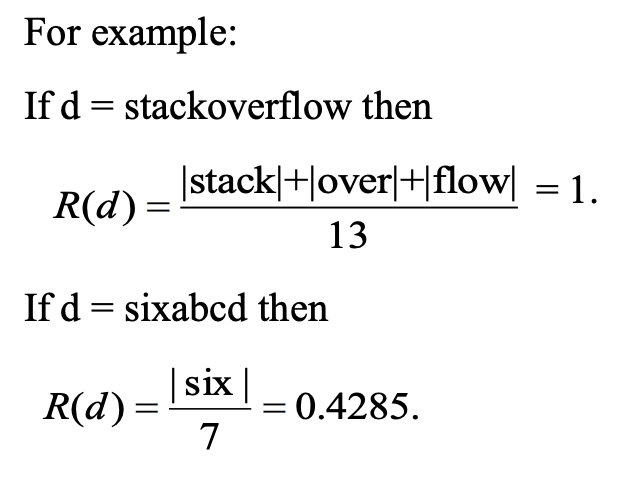

In [0]:
# Tong-Van-Van_Nguyen-Linh-Giang-Detection-of-DGA-Botnet_En-V2.6-2016-Nov10
def MCR(domain): #meaningful characters ratio
  domain = removeWWW(domain)
  meaningfulwordsindomain = findMeaningfulWords(cleanwordlist(list(MeaningfulChars(domain)), domain), domain)
  lengthofdomain = max(float(len(domain.split(".", 1)[0])), 1.0)
  zz = meaningfulwordsindomain/lengthofdomain
  return min(zz,1.0) #1 is max value


In [0]:
#TESTS
print(MCR("egoogsedatexy-65.com"))
print(MCR("stackoverflow.com"))
print(MCR("sixabcd")) #it counts abc as valid ngram in google's ngram list

0.25
1.0
0.8571428571428571


In [0]:
p1_data['MCR'] = p1_data.dns.apply(lambda x: MCR(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: generator 'ngrams' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


??????
??????
??????
??????
??????
??????
??????
??????
??????
??????
??????
??????
??????
??????
??????
??????
??????
??????
icmsb2019(at)163
icmsb2019(at)163
icmsb2019(at)163
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
www??????
icnisc2019(at)163
icnisc2019(at)163
icnisc2019(at)163
???
???
???
???
???
???
???
???
???
icmesd2019&163
icmesd2019&163
icmesd2019&163
icmesd2019&163
icmesd2019&163
icmesd2019&163
www???
www???
www???
www???
www???
www???
www???
www???
www???
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
???????
http://steamcommunity
http://steamcommunity
http://steamcommunity
http://steamcommunity
http://steamcommunity
http://steamcommunity
esem2019&163
esem2019&163
esem2019&163
esem2019&163
esem2019&163
esem2019&163
?????
?????
?????
????

In [0]:
p1_data

,dns,family,dnsLength,MCR
47677,scylgroup.com,0,13,0.555556
48162,effilnuds.com,0,13,0.000000
28840,lovebookonline.com,0,18,0.928571
4204,wwww91k.com,0,11,0.428571
30276,93c53.com,0,9,0.000000
...,...,...,...,...
18523,sousoucili.com,0,14,0.000000
44739,ngmc.com,0,8,0.000000
47734,weborama.fr,0,11,0.750000
40259,mg4150.com,0,10,0.000000


In [0]:
p1_data.loc[p1_data['MCR'].idxmax()]

dns          chinadahong.com
family                     0
dnsLength                 15
MCR                        1
Name: 26598, dtype: object

In [0]:
mask = p1_data['family'].isin([0])
df = p1_data[mask]
df
df2 = p1_data[~mask]
df2

,dns,family,dnsLength,MCR
2932,6n9qw0bwjrh11s2379ibuv3jr.biz,1,29,0.000000
17418,frontiersmeet.org,1,17,1.000000
7191,vqshjbnrijizusvwpzxjveix.info,1,29,0.125000
23000,bjopycmsmimst.org,1,17,0.230769
3424,frdcc.cc,1,8,0.000000
...,...,...,...,...
45195,knvn6i1bc3t2u5nuoz4d983x.net,1,28,0.000000
34762,kcjoyhciylyyna.ru,1,17,0.214286
20039,vozlldytkqsxwzuslzcqtsrwnj.biz,1,30,0.115385
32387,csbntakpufjebb.net,1,18,0.000000


In [0]:
ngt2['MCR'] = ngt2.domain.apply(lambda x: MCR(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: generator 'ngrams' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
ngt2.rename(columns={'domain': 'dns'}, inplace=True)
df3 = pd.concat([df,ngt2])


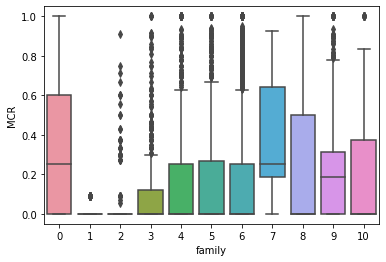

In [0]:
sns.boxplot(x='family', y='MCR', data=df3) #family 0 is non malicious. families 1-10 are malicious

In [0]:
# df3 = df3.drop('dnsLength', 1)
# df3
#df3['dnsLength'] = df3.dns.apply(lambda x: len(x))

In [0]:
#df3.dns
df3['dnsLength'] = df3.dns.apply(lambda x: len(str(x)))
df3

,dns,family,dnsLength,MCR
47677,scylgroup.com,0,13,0.555556
48162,effilnuds.com,0,13,0.000000
28840,lovebookonline.com,0,18,0.928571
4204,wwww91k.com,0,11,0.428571
30276,93c53.com,0,9,0.000000
...,...,...,...,...
11090,gdwrhiivyt.cc,10,13,0.000000
11091,hyirnrnetku.cc,10,14,0.272727
11092,isauvvu.cc,10,10,0.428571
11093,vddiuiygf.cc,10,12,0.000000


In [0]:
df4 = ngt2.copy()
df4 = pd.concat([safedomain, df4])
df4

,dns,family,dnsLength,MCR
47677,scylgroup,0,13.0,NaN
48162,effilnuds,0,13.0,NaN
28840,lovebookonline,0,18.0,NaN
4204,wwww91k,0,11.0,NaN
30276,93c53,0,9.0,NaN
...,...,...,...,...
11090,gdwrhiivyt.cc,10,NaN,0.000000
11091,hyirnrnetku.cc,10,NaN,0.272727
11092,isauvvu.cc,10,NaN,0.428571
11093,vddiuiygf.cc,10,NaN,0.000000


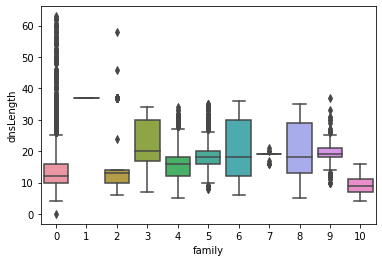

In [0]:
sns.boxplot(x='family', y='dnsLength', data=df3) #family 0 is non malicious. families 1-10 are malicious. 
#this plot shows us some of the families have high variance in their dns length. length seems very useful for family 7 however.


In [0]:
#ngt2 is dataframe with all the malicious families 1-10
#p1_data is dataframe with all of the domains

In [0]:
ngt2

,dns,family,MCR
0,z54f71fcb61e49158f3648236556b04eb1.so,1,0.000000
1,l31f5dcf7f398d2b94cd9155ee392c701b.so,1,0.000000
2,d442a48406424819e686a5d1fde7c602ea.so,1,0.000000
3,zba909e91846ce27aff7902f9228ee40ea.so,1,0.000000
4,p8f5889e854374cf8e70e91f456807f83f.so,1,0.000000
...,...,...,...
11090,gdwrhiivyt.cc,10,0.000000
11091,hyirnrnetku.cc,10,0.272727
11092,isauvvu.cc,10,0.428571
11093,vddiuiygf.cc,10,0.000000


In [0]:
alexadataframe = ngt2.copy()


In [0]:
alexadataframe

,dns,family,MCR
0,z54f71fcb61e49158f3648236556b04eb1.so,1,0.000000
1,l31f5dcf7f398d2b94cd9155ee392c701b.so,1,0.000000
2,d442a48406424819e686a5d1fde7c602ea.so,1,0.000000
3,zba909e91846ce27aff7902f9228ee40ea.so,1,0.000000
4,p8f5889e854374cf8e70e91f456807f83f.so,1,0.000000
...,...,...,...
11090,gdwrhiivyt.cc,10,0.000000
11091,hyirnrnetku.cc,10,0.272727
11092,isauvvu.cc,10,0.428571
11093,vddiuiygf.cc,10,0.000000


In [0]:
ngt2['1gramscore'] = ngt2.dns.apply(lambda x: getngramscore(cleandomain(x),1))
ngt2['2gramscore'] = ngt2.dns.apply(lambda x: getngramscore(cleandomain(x), 2))
ngt2['entropy1gram'] = ngt2.dns.apply(lambda x: getentropy(cleandomain(x)))
ngt2['entropy2grams'] = ngt2.dns.apply(lambda x: getentropy2grams(cleandomain(x)))





In [0]:
ngt2

,dns,family,MCR,1gramscore,2gramscore,entropy1gram,entropy2grams
0,z54f71fcb61e49158f3648236556b04eb1.so,1,0.000000,0.018329,0.000529,2.316452,6.131812
1,l31f5dcf7f398d2b94cd9155ee392c701b.so,1,0.000000,0.021779,0.000544,1.997994,6.235772
2,d442a48406424819e686a5d1fde7c602ea.so,1,0.000000,0.023669,0.000595,2.229341,6.252174
3,zba909e91846ce27aff7902f9228ee40ea.so,1,0.000000,0.026047,0.000773,2.105525,5.975712
4,p8f5889e854374cf8e70e91f456807f83f.so,1,0.000000,0.018927,0.000452,2.572601,6.360902
...,...,...,...,...,...,...,...
11090,gdwrhiivyt.cc,10,0.000000,0.036241,0.001002,1.753625,7.139158
11091,hyirnrnetku.cc,10,0.272727,0.040654,0.001732,1.596660,6.390770
11092,isauvvu.cc,10,0.428571,0.036844,0.001191,2.717746,7.669172
11093,vddiuiygf.cc,10,0.000000,0.033001,0.001147,2.302538,7.070121


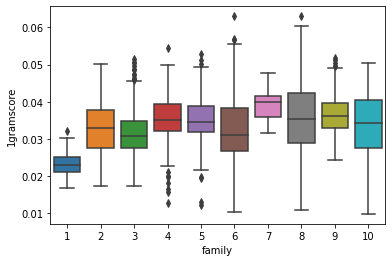

In [0]:
sns.boxplot(x='family', y='1gramscore', data=ngt2) 

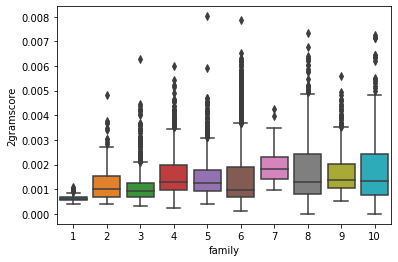

In [0]:
sns.boxplot(x='family', y='2gramscore', data=ngt2) 

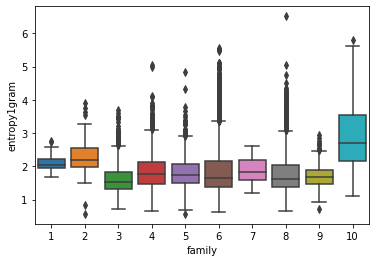

In [0]:
sns.boxplot(x='family', y='entropy1gram', data=ngt2) 

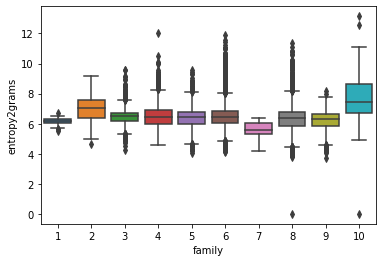

In [0]:
sns.boxplot(x='family', y='entropy2grams', data=ngt2) 

In [0]:
safedomain

,dns,family,dnsLength
47677,scylgroup,0,13
48162,effilnuds,0,13
28840,lovebookonline,0,18
4204,wwww91k,0,11
30276,93c53,0,9
...,...,...,...
1661,creditcardcity,0,18
18523,sousoucili,0,14
44739,ngmc,0,8
47734,weborama,0,11


#These are poor results. we will now try with alexa top million. Perhaps the original data is biased. 

In [0]:
alexadataframe['1gramscore'] = alexadataframe.dns.apply(lambda x: math.log(getalexangramscore(cleandomain(x),1)+1)) 
alexadataframe['2gramscore'] = alexadataframe.dns.apply(lambda x: math.log(getalexangramscore(cleandomain(x),2)+1))
alexadataframe['3gramscore'] = alexadataframe.dns.apply(lambda x: math.log((getalexangramscore(cleandomain(x),3)+1)))  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


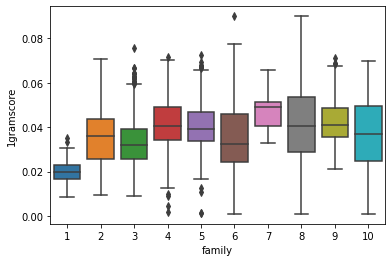

In [0]:
sns.boxplot(x='family', y='1gramscore', data=alexadataframe) 

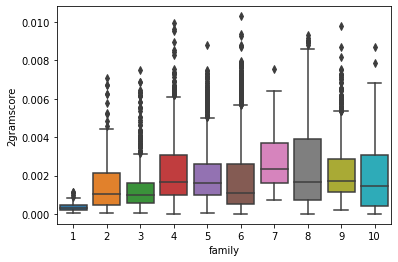

In [0]:
sns.boxplot(x='family', y='2gramscore', data=alexadataframe) 

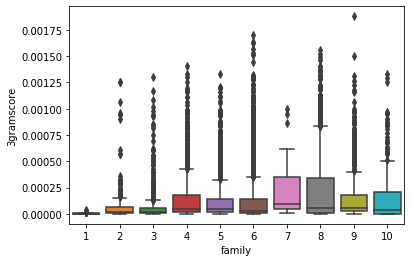

In [0]:
sns.boxplot(x='family', y='3gramscore', data=alexadataframe) 

In [0]:
alexadataframe['4gramscore'] = alexadataframe.dns.apply(lambda x: math.log(100*getalexangramscore(cleandomain(x),4)+1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


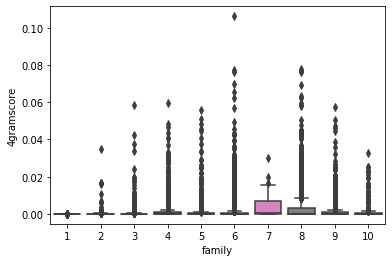

In [0]:
sns.boxplot(x='family', y='4gramscore', data=alexadataframe) 

In [0]:
alexadataframe['5gramscore'] = alexadataframe.dns.apply(lambda x: math.log(100*getalexangramscore(cleandomain(x),5)+1)) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


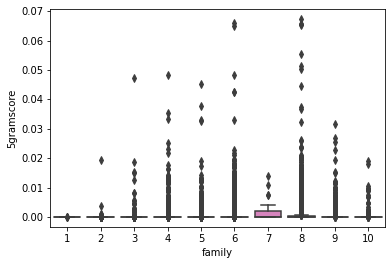

In [0]:
sns.boxplot(x='family', y='5gramscore', data=alexadataframe) 

In [0]:
alexadataframe['entropy1gram'] = alexadataframe.dns.apply(lambda x: getalexaentropy(cleandomain(x)))
alexadataframe['entropy2grams'] = alexadataframe.dns.apply(lambda x: getalexaentropy2grams(cleandomain(x)))

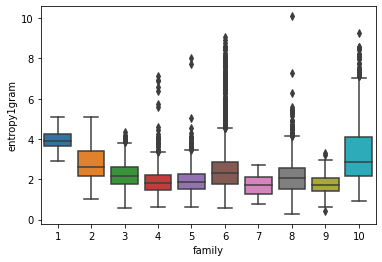

In [0]:
sns.boxplot(x='family', y='entropy1gram', data=alexadataframe) 


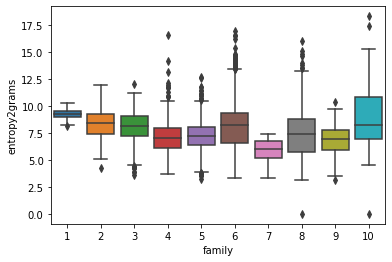

In [0]:
sns.boxplot(x='family', y='entropy2grams', data=alexadataframe) 

In [0]:
alexadataframe['dnsLength'] = alexadataframe.dns.apply(lambda x: len(str(x)))

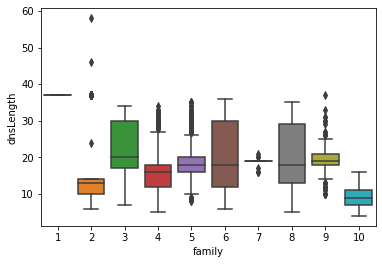

In [0]:
sns.boxplot(x='family', y='dnsLength', data=alexadataframe) 

#We achieve improved results from using Alexa top million domains